In [1]:
!gpu-who

n109.mcl.weizmann.ac.il  Sat Sep  9 20:22:58 2023  450.80.02
[0] Quadro RTX 8000  | 37'C,   0 % |     0 / 48601 MB |
[1] Quadro RTX 8000  | 35'C,   0 % |     0 / 48601 MB |
[2] Quadro RTX 8000  | 34'C,   0 % |     0 / 48601 MB |
[3] Quadro RTX 8000  | 36'C,   0 % |     0 / 48601 MB |
[4] Quadro RTX 8000  | 34'C,   0 % |     0 / 48601 MB |
[5] Quadro RTX 8000  | 36'C,   0 % |     0 / 48601 MB |
[6] Quadro RTX 8000  | 35'C,   0 % |     0 / 48601 MB |
[7] Quadro RTX 8000  | 34'C,   0 % |  4829 / 48601 MB | itaian(3315M) itaian(1511M)


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from import_for_notebooks import *
torch.set_default_dtype(torch.float64)

import common_utils
import analysis
import analysis_utils
from analysis import find_nearest_neighbour, scale, sort_by_metric

IMPORTANT IMPORTED! 2023-09-09 20:23:00.215977
device=cuda:0


In [3]:
# in case you have your own sweep:
# sweep_id = '3s9e7mys'
# sweeps_dir = './data/sweeps/'
# sweep = analysis_utils.read_sweep(sweeps_dir, sweep_id, name=None, problem='cifar10_vehicles_animals')
# analysis_utils.download_sweep_results_from_wandb(sweep, max_runs_to_download=100)
# X = analysis_utils.get_all_reconstruction_outputs(sweep, verbose=True)

# read sweep parameters
sweep = common_utils.common.load_dict_to_obj("./reconstructions/multiclass/sweep.txt")
# read model, data, and whatever needed
args, Xtrn, Ytrn, ds_mean, W, model = analysis_utils.sweep_get_data_model(sweep, put_in_sweep=True, run_train_test=True)

OUTPUT_DIR: /home/gonb/data/projects_data/decoreco/runs/2023_09_09_20_23_00_415538_cifar10_multiclass_d50_cifar10_multiclass_d50_wd0_init0.0001
Namespace(cuda=True, data_per_class_test=1000, data_per_class_train=50, data_per_class_val=0, data_reduce_mean=True, datasets_dir='/home/gonb/data/datasets', device=device(type='cuda', index=0), extract_save_results=True, extract_save_results_every=10000, extraction_data_amount_per_class=100, extraction_epochs=50001, extraction_evaluate_rate=1000, extraction_init_scale=0.000360518547049631, extraction_lambda_lr=0.9512763978427656, extraction_loss_type='kkt', extraction_lr=0.00024198142474905472, extraction_lr_l=0.0001, extraction_lr_x=0.0001, extraction_min_lambda=0.04011794836931207, extraction_model_activation='modifiedrelu', extraction_model_relu_alpha=326.46588669096246, extraction_regression=False, extraction_stop_threshold=5000, model_hidden_list=[1000, 1000], model_init_list=[0.0001, 0.0001], model_name='cifar10_multiclass_d50_cifar10_mu

In [4]:
# Read Reconstructed Data:

# "X" will contain a batch of all reconstructed samples (not all of them are good.. for this we need the rest of the cell)
# Here we put reconstructed data from two diffferent runs.
# you can use both of them or just one. (uncomment relevant parts)
x_paths = [
    './reconstructions/multiclass/run1_x.pth',
    './reconstructions/multiclass/run2_x.pth'
]
# X = torch.load(x_paths[0])
# X = torch.load(x_paths[1])
X = torch.cat([torch.load(x_paths[0]), torch.load(x_paths[1])])

CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60


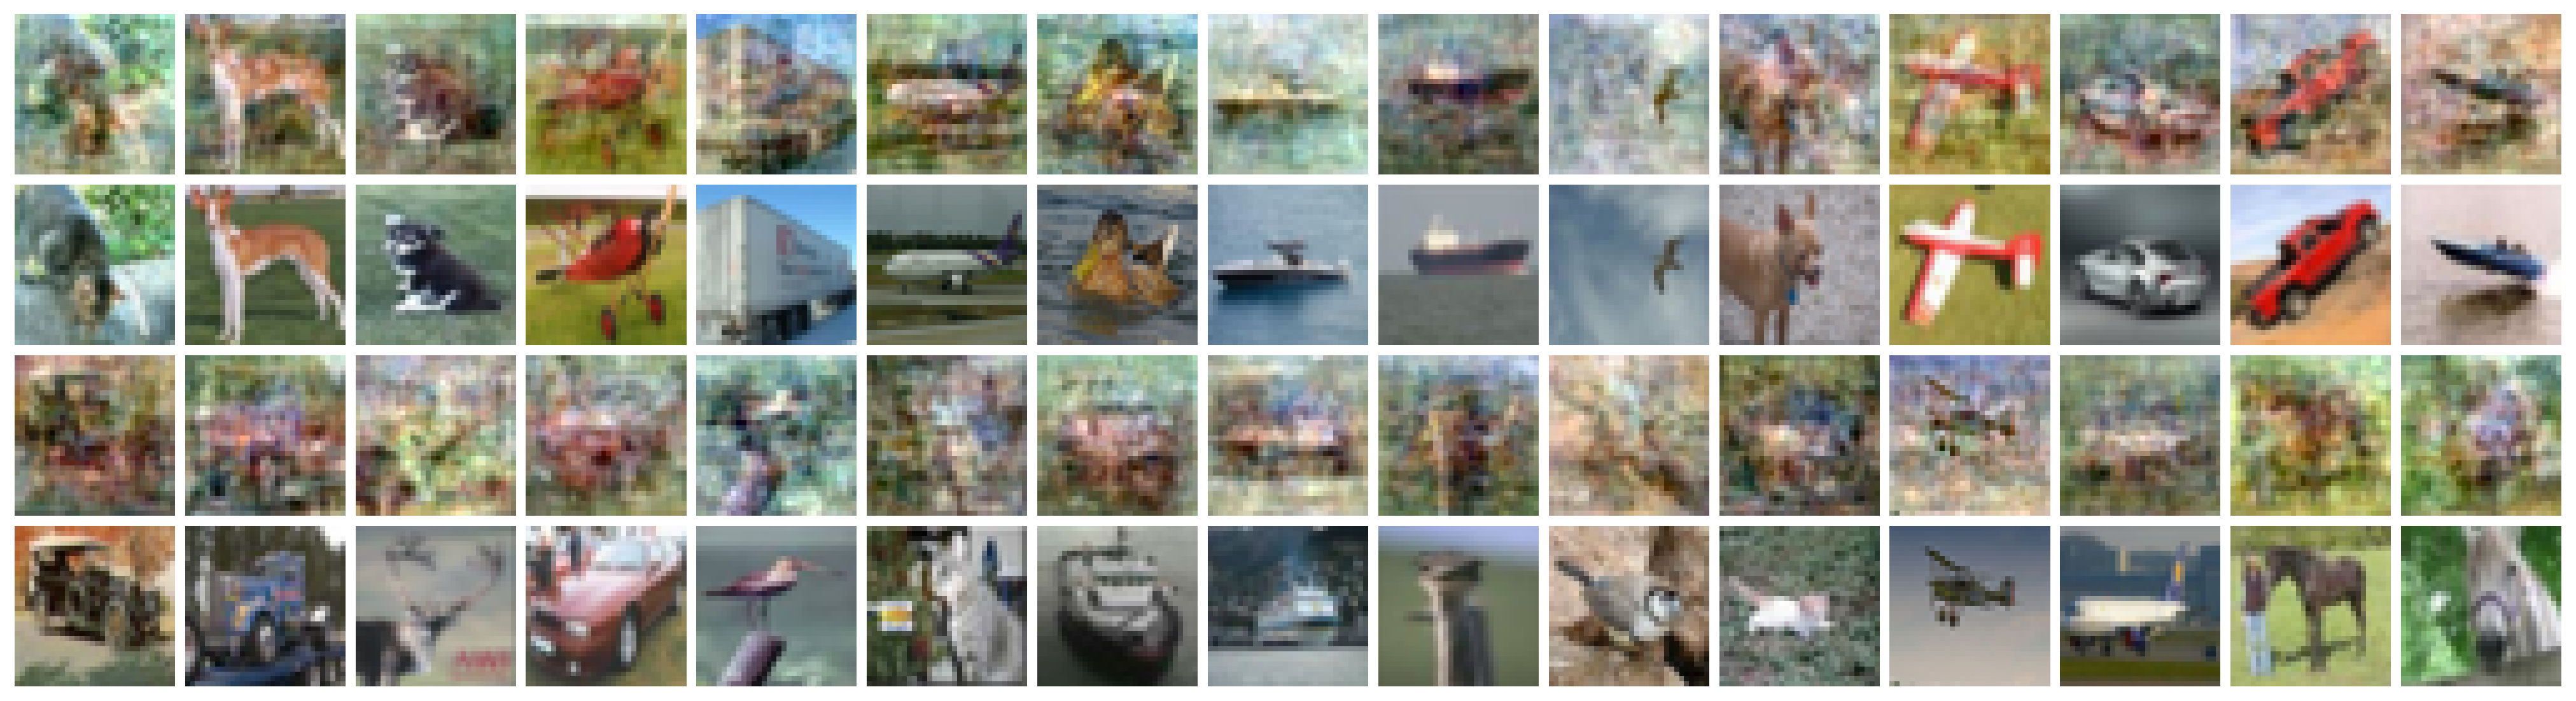

DONE!


In [5]:
# Find "Good" Resonctructions:

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc2', vote='min', use_bb=False, nn_threshold=1000)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# # Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
values = model(Xtrn).data

# Plot
# color_by_labels = Ytrn[sort_idxs]
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)

### Show Weights of first Layer

CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([990, 3, 32, 32]) 66


  0%|          | 0/17 [00:00<?, ?it/s]

0 0 60


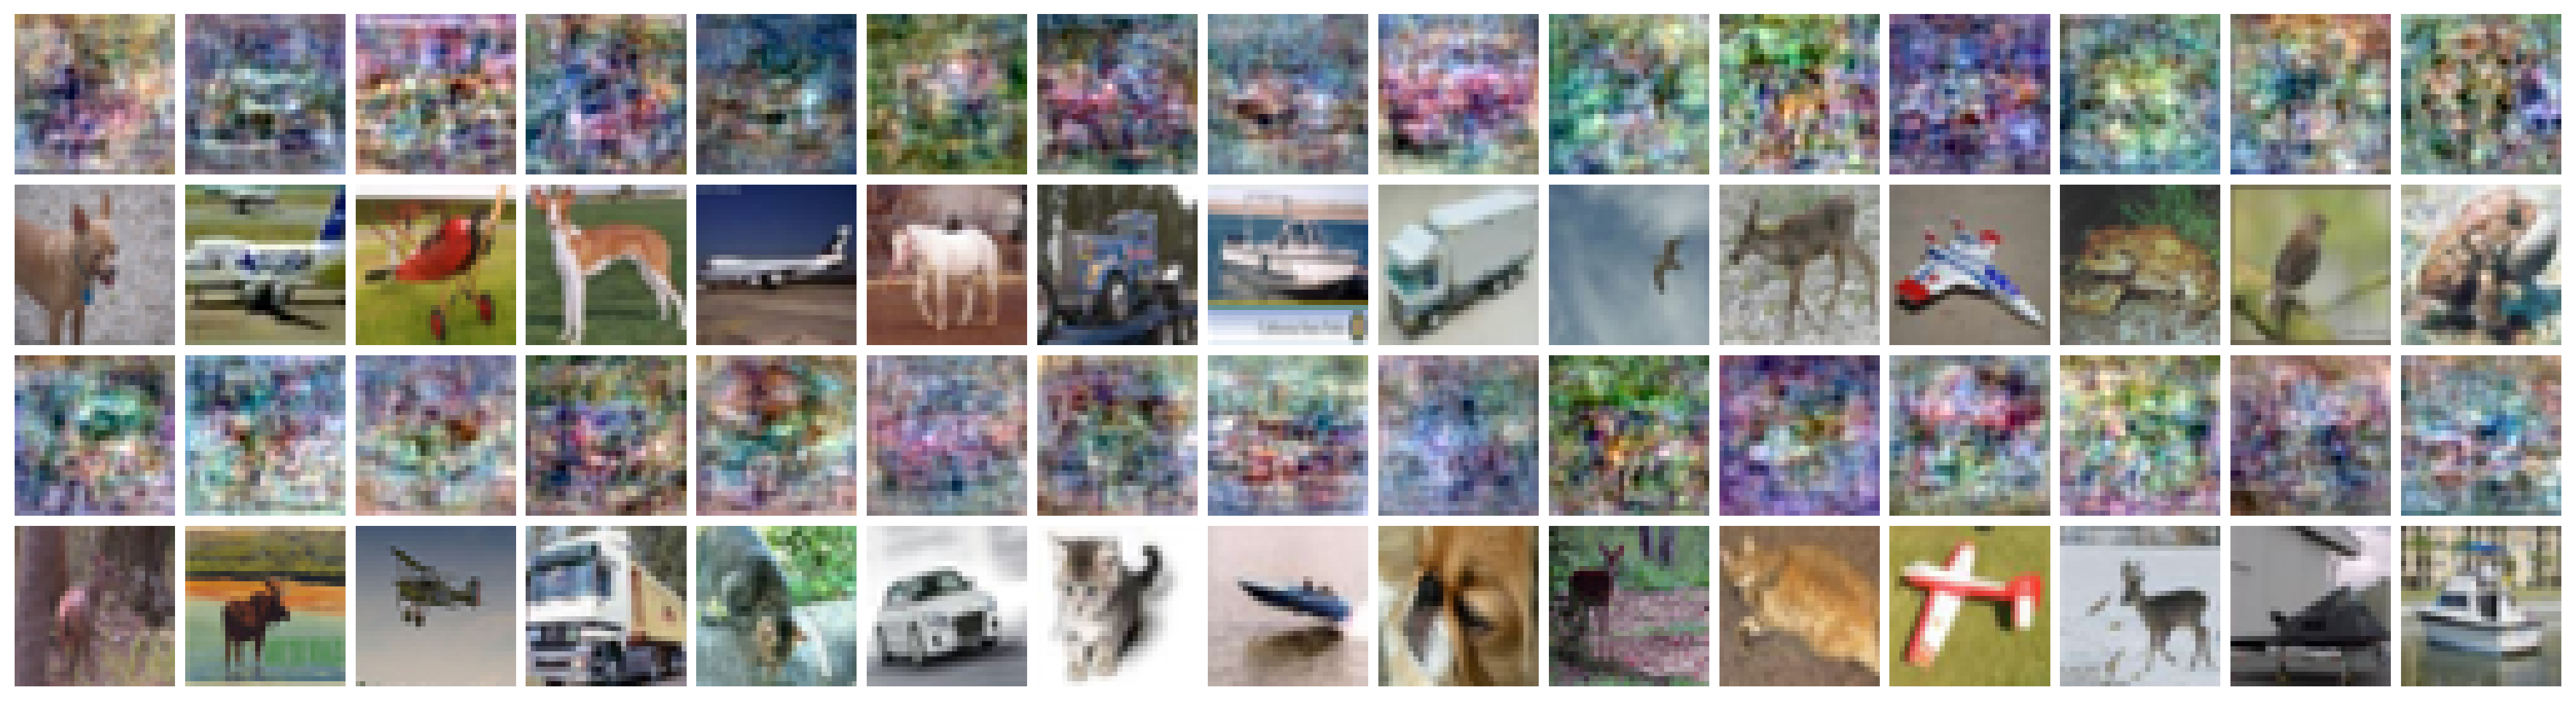

DONE!


In [6]:
# Show how the weights of the first layer looks like, for comparison.
# Note that some data samples can be found in the first layer, but not as near as many that can be reconstructed using our approach.

X = sweep.W.reshape(sweep.W.shape[0], 3, 32, 32) 

# Find Nearest Neighbour
# xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='min', use_bb=False, nn_threshold=None)
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc', vote='mean', use_bb=True, nn_threshold=1.1)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean, xx_add_ds_mean=False)
# Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
# Plot
analysis.plot_table(xx, yy, fig_elms_in_line=15, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=None, figpath=None, show=True, dpi=100)